In [1]:
import cv2
import numpy as np
from tqdm import trange
from flygym import Simulation, Camera
from flygym.arena import FlatTerrain

In this example, we will simulate a fly chasing another fly based on vision. This is similar to the [visual taxis task in week 4](https://github.com/NeLy-EPFL/cobar-exercises/blob/main/week4/1_vision.ipynb), but the ball will be replaced by a walking fly.

For multi-fly simulation, we might want to control the flies differently and have different observation/action spaces for different flies. Therefore, we will inherit from `Fly` and implement different logic in the `pre_step` method.

In [ ]:
from hybrid_turning_fly import HybridTurningFly

In [2]:
class VisualTaxisFly(HybridTurningFly):
    def __init__(self, obj_threshold=0.15, decision_interval=0.05, **kwargs):
        super().__init__(**kwargs, enable_vision=True)
        self.obj_threshold = obj_threshold
        self.decision_interval = decision_interval
        self.num_substeps = int(self.decision_interval / self.timestep)
        self.visual_inputs_hist = []

        self.coms = np.empty((self.retina.num_ommatidia_per_eye, 2))

        for i in range(self.retina.num_ommatidia_per_eye):
            mask = self.retina.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

    def process_visual_observation(self, vision_input):
        features = np.zeros((2, 3))

        for i, ommatidia_readings in enumerate(vision_input):
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj_coords = self.coms[is_obj]

            if is_obj_coords.shape[0] > 0:
                features[i, :2] = is_obj_coords.mean(axis=0)

            features[i, 2] = is_obj_coords.shape[0]

        features[:, 0] /= self.retina.nrows  # normalize y_center
        features[:, 1] /= self.retina.ncols  # normalize x_center
        features[:, 2] /= self.retina.num_ommatidia_per_eye  # normalize area
        return features.ravel().astype("float32")

    @staticmethod
    def calc_ipsilateral_speed(deviation, is_found):
        if not is_found:
            return 1.0
        else:
            return np.clip(1 - deviation * 3, 0.4, 1.2)

In [3]:
timestep = 1e-4

fly0 = VisualTaxisFly(
    name="0",
    timestep=timestep,
    enable_adhesion=True,
    head_stabilization_model="thorax",
    neck_kp=1000,
)

fly1 = HybridTurningFly(
    name="1",
    timestep=timestep,
    enable_adhesion=True,
    spawn_pos=(6, 0, 0.5),
)

arena = FlatTerrain()

birdeye_cam_zoom = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam_zoom",
    mode="fixed",
    pos=(15, 0, 20),
    euler=(0, 0, 0),
    fovy=45,
)

birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam",
    mode="fixed",
    pos=(15, 0, 35),
    euler=(0, 0, 0),
    fovy=45,
)

cam = Camera(
    fly=fly0,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(800, 608),
)

sim = Simulation(
    flies=[fly0, fly1],
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)

In [4]:
sim.reset(seed=0)
for i in fly1.model.find_all("geom"):
    sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

run_time = 3
t = np.arange(0, run_time, timestep)

fly1_actions = (
    np.column_stack(
        [
            np.abs(np.cos(t * np.pi / 2)),
            np.abs(np.sin(t * np.pi / 2)),
        ]
    )
    * 1.2
)

second_cam_frames = []
fly0_action = np.zeros(2)
x = None
alpha = 1e-1

for i in trange(len(t)):
    obs, _, _, _, info = sim.step(
        {
            "0": fly0_action,
            "1": fly1_actions[i],
        }
    )

    obs0, info0 = obs["0"], info["0"]
    render_res = sim.render()[0]

    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)

    visual_features = fly0.process_visual_observation(obs0["vision"])

    left_deviation = 1 - visual_features[1]
    right_deviation = visual_features[4]
    left_found = visual_features[2] > 0.005
    right_found = visual_features[5] > 0.005

    if not left_found:
        left_deviation = np.nan

    if not right_found:
        right_deviation = np.nan

    fly0_action = np.array(
        [
            fly0.calc_ipsilateral_speed(left_deviation, left_found),
            fly0.calc_ipsilateral_speed(right_deviation, right_found),
        ]
    )

100%|██████████| 30000/30000 [03:29<00:00, 142.93it/s]


In [5]:
birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames

In [6]:
from flygym.vision import save_video_with_vision_insets

sim.fly = fly0

save_video_with_vision_insets(
    sim,
    cam,
    "outputs/fly_following_with_retina_images.mp4",
    fly0.visual_inputs_hist,
)

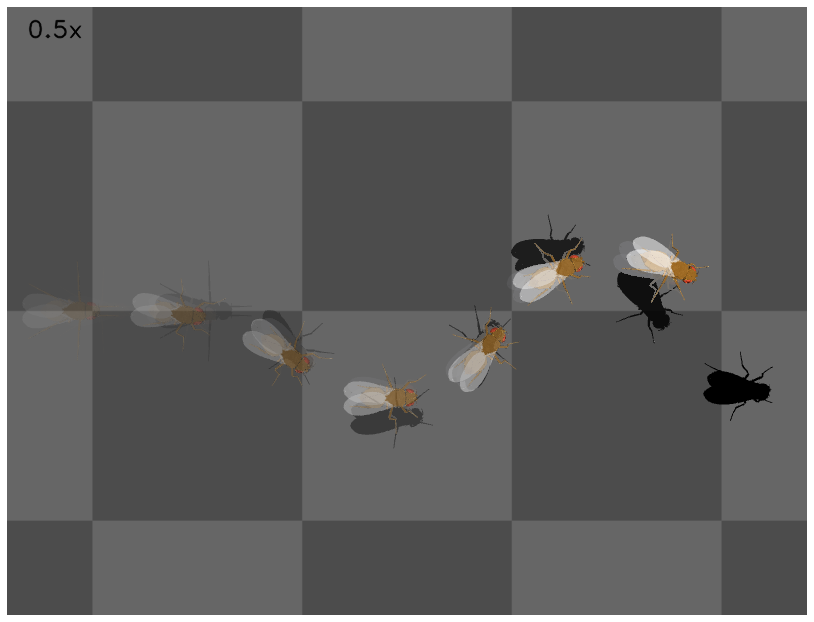

In [7]:
from pathlib import Path
import imageio
import matplotlib.pyplot as plt

frame_indices = np.arange(0, len(birdeye_cam_frames), 30)[:8]
snapshots = [birdeye_cam_frames[i] for i in frame_indices]
background = np.median(snapshots, axis=0).astype("uint8")

individual_frames_dir = Path("outputs/individual_frames")
individual_frames_dir.mkdir(parents=True, exist_ok=True)

imageio.imwrite(individual_frames_dir / "background.png", background)
imgs = []

for i, img in enumerate(snapshots):
    is_background = np.isclose(img, background, atol=1).all(axis=2)
    img_alpha = np.ones((img.shape[0], img.shape[1], 4)) * 255
    img_alpha[:, :, :3] = img
    img_alpha[is_background, 3] = 0
    img_alpha = img_alpha.astype(np.uint8)
    imageio.imwrite(individual_frames_dir / f"frame_{i}.png", img_alpha)
    imgs.append(img_alpha.copy())

dpi = 72
h, w = background.shape[:2]

fig, ax = plt.subplots(figsize=(w / dpi, h / dpi), dpi=72)
ax.imshow(background)
ax.axis("off")

for i, img in enumerate(imgs):
    ax.imshow(img, alpha=(i + 1) / len(imgs))

fig.subplots_adjust(0, 0, 1, 1, 0, 0)
plt.savefig("outputs/overlayed_frames.pdf", dpi=dpi)